Técnicas de reducción de dimensionalidad
===================================

## Introducción

Topic modeling es una técnica de aprendizaje automático no supervisado donde intentados descubrir tópicos que son abstractos al texto pero que pueden describir una colección de documentos. Es importante marcar que estos "tópicos" no son necesariamente equivalentes a la interpretación coloquial de tópicos, sino que responden a un patrón que emerge de las palabras que están en los documentos.

La suposición básica para Topic Modeling es que cada documento está representado por una mescla de tópicos, y cada tópico consiste en una colección de palabras.

### Para ejecutar este notebook

Para ejecutar este notebook, instale las siguientes librerias:

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv \
    --quiet --no-clobber --directory-prefix ./Datasets/mascorpus/
    
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/nlp/modeling/topic-modeling.txt \
    --quiet --no-clobber
!pip install -r topic-modeling.txt

In [ ]:
!python -m spacy download es_core_news_sm

Primero importaremos algunas librerias necesarias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Sobre el set de datos con el que vamos a trabajar

Utilizaremos como ejemplo un set de datos en español que contiene tweets que diferentes usuarios han publicado en relación a diferentes marcas de productos u empresas en el rubro de alimentación, construcción, automoviles, etc. Estos tweets, a su vez, están asociados a una de las diferentes fases en el proceso de ventas (también conocido como Marketing Funel) y por eso están tagueados con las fases de:
 - Awareness – el cliente es conciente de la existencia de un producto o servicio
 - Interest – activamente expresa el interes de un producto o servicio
 - Evaluation – aspira una marca o producto en particular
 - Purchase – toma el siguiente paso necesario para comprar el producto o servicio
 - Postpurchase - realización del proceso de compra. El cliente compara la diferencia entre lo que deseaba y lo que obtuvo

Referencia: [Spanish Corpus of Tweets for Marketing](http://ceur-ws.org/Vol-2111/paper1.pdf

> Nota: La version de este conjunto de datos que utilizaremos aqui es una versión preprocesada del original.

In [5]:
tweets = pd.read_csv('Datasets/mascorpus/tweets_marketing.csv')

Inspeccionamos el set de datos

In [6]:
tweets.head(5)

,TEXTO,SECTOR,MARCA,CANAL,AWARENESS,EVALUATION,PURCHASE,POSTPURCHASE,NC2
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
1,#tr Me ofrezco para montar muebles de Ikea - H...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,RETAIL,ALCAMPO,Microblog,0,0,0.0,0,1.0
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0
4,$Carrefour retira pez #Panga. OCU y grupos x #...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0


In [7]:
tweets.groupby('SECTOR').head(1)[['TEXTO', 'SECTOR']]

,TEXTO,SECTOR
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL
725,"""Ilcinsisti lis MB dispiniblis"" te odeeeeeo Mo...",TELCO
964,#CarlosSlim y Bimbo lanzarán un vehículo eléct...,ALIMENTACION
1298,"‼🏎Toyota #Day, 4ruedas ,1/4 milla, 1 #pasión, ...",AUTOMOCION
1748,"""- Tú qué.\n- Yo na.""\nConversaciones banco sa...",BANCA
2348,"- Cariño, te juro que sólo tenían Cruzcampo en...",BEBIDAS
3023,#adidas #hockey Amenabar 2080 CABA https://t.c...,DEPORTES


## Preprosesamiento

Como en toda tarea de NLP, y más generalmente, en Machine Learning, ocuparemos una porción de nuestro tiempo en preprocesar los datos para generar representaciones útiles y deshacernos de problemas especificos que podría exhibir nuestro set de datos. 

### Creando una rutina de preprosesamiento de texto

Realizaremos las tareas cotidianas de preprocesamiento. Adicionalmente nuestra rutina va a: 

 - Eliminar caracteres especiales: Acentos y caracteres especiales podrían complejizar el la representación de palabras, por lo que los eliminaremos.
 - Eliminaremos URLs y handles que son típicos en tweeter. Esto es especifico en este set de datos ya que una URL no representa información en este contexto.

In [8]:
import unidecode
import spacy
import es_core_news_sm as spa
import re
from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer

nltk.download('stopwords', quiet=True)

parser = spa.load() # Cargamos el parser en español
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) # Creamos un tokenizer
stemmer = stem.SnowballStemmer(language='spanish') # Creamos un steammer
lemmatizer = lambda word : " ".join([token.lemma_ for token in parser(word)]) # Creamos un lemmatizer
stopwords = set(stopwords.words('spanish')) # Instanciamos las stopwords en español
urls_regex = re.compile('http\S+') # Usamos una expresion regular para encontrar las URLs

def process_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not re.match(urls_regex, token)]
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [unidecode.unidecode(token) for token in tokens] # Quitamos acentos
    tokens = [lemmatizer(token) for token in tokens]
    return tokens

In [9]:
doc_list = []

for doc in tqdm(tweets['TEXTO']):
    tokens = process_text(doc)
    doc_list.append(' '.join(tokens))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3763/3763 [01:54<00:00, 32.98it/s]


Revisemos algunos resultados:

In [ ]:
tweets['TEXTO'][2]

'#VozPópuli Vozpópuli @voz_populi - #LoMásLeidoHoy Mercadona, DIA o Alcampo guardan silencio ante la ola europea... https://t.co/aJTuA4J9UV'

In [ ]:
doc_list[2]

'# VozPopuli Vozpopuli # LoMasLeidoHoy Mercadona Alcampo guardar silenciar europeo'

In [ ]:
len(doc_list)

3763

## Vectorización

Una vez que nuesto texto fue preprocesado para mantener solo aquellas palabras que nos son relevantes, pasamos al proceso de generar vectores a partir de las palabras que componen nuestro vocabulario. Nuestros modelos no pueden operar sobre palabras, y por lo tanto necesitamos una representación númerica de las mismas.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, sublinear_tf=True, norm='l2')
vectors = vectorizer.fit_transform(doc_list).todense()

In [ ]:
vectors.shape

## Reducción de dimensionalidad: Featurization
Una vez que tenemos nuestros palabras representadas como vectores, nos aparece el problema de que ¡aún son demasiado grandes! En el ejemplo anterior, estamos trabajando con vectores en un espacio de 6K+. Necesitamos reducir esta dimensionalidad. Para esto, utilizaremos métodos de reducción de dimensionalidad con el objetivo de generar features que nos sean más utiles. Estas features las generaremos de forma "no supervisada"

### Métodos básados en SVD

Los modelos basados en factorización de matrices intentan reducir la dimensionalidad de la matriz al aproximarla usando dos matrices que representan embeddings de palabras y embeddings de documentos (más una matriz singular que los vincula los unos con los otros). Este método es bastante popular no solo en NLP sino que también en sistemas de recomendación, método que fué ganador del Netflix Prize (Funk SVD).

<img src="https://miro.medium.com/max/700/1*Z0EUVs7QElEqRqXtqut_FQ.png" />


U y V(trapuesta) son ortogonales. Esto es de esperar porque si determinadas propiedades determinan un determinado factor latente, entonces esas propiedades serán poco relevantes en los restantes factores (pues sino, no haría sentido que conformen un factor distinto en un primer lugar).

SVC es un metodo de decomposición exacto, lo que singnifica que las matrices U y V son lo suficientemente grandes para mapear exactamente la matriz A. 

### LSI - Latent Semantic Indexing

LSI es un caso particular de factorización de matrices. Cuando SVD es utilizado para procesar tópicos en texto y en donde los valores de la matriz A corresponden a frecuencias de palabras, este método se lo denomina Latent Semantic Analysis (sin embargo, en NLP no se lo suele nombrar como LSI).

Dado que SVC es un método de decomposición exacto, tiende a producir matrices de poca densidad (sparse). Para evitar este problema, se utiliza una versión modificada de SVC conocida como Truncated SVD que solamente computa los k componentes mas grandes en la descomposición. Esto ayuda a que LSI combata efectivamente el problema de matrices sparse que tienden a generarse cuando se tienen cuerpos de texto con sinónimos y palabras que significan varias cosas dependiendo del contexto. Truncated SVD evíta ser un método de decomposición exacto al aproximar la matriz A utilizando los k tópicos más relevantes.

<img src='https://github.com/fastai/course-nlp/raw/aabfeddf61fea29b18c72f841d057b56a216b7eb/images/svd_fb.png' />

Facebook Research: Fast Randomized SVD [https://research.fb.com/fast-randomized-svd/])

En esta configuración entonces:
 - Un documento es nada mas que la distribución de palabras que ocurren en el (Bag of words)
 - A es una matriz de m x n donde m es la cantidad de documentos ú observaciones, y n es la cantidad de palabras en el vocabulario.
 - Los valores de A corresponden a la frecuencia de la cada palabra del vocabulario en cada observación ú documento.
 - A es una matriz sujeta a ruido con distribución Gausiana.


Referencia: Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions [https://arxiv.org/abs/0909.4061]

El principal parametro en LSI es el numero de factores que queremos generar (el parametro K). No existe una regla para especificar este parametro ya que depende del escenario. Valores muy pequeños pueden forzar a los documentos a ser colisionar en los tópicos que son asignados, mientras que valores muy grandes pueden hacer que palabras poco frecuentes y raras terminen determinando su propio "topico". Este valor lo especificaremos en n_components. El parametro algorithm hace referencia al método que utilizaremos para generar la descomposición:

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=7, algorithm='randomized')
USigma = svd.fit_transform(vectors)
Sigma = svd.singular_values_
VT = svd.components_

Si bien en el codigo anterior estamos viendo las 3 matrices, solo nos interesa la matriz VT. ¿Porque? Recuerden que nuestro "input" es un conjunto de palabras que luego vectorizamos utilizando TF-IDF. Cada documento está representado por este conjunto de palabras. Nuestro objetivo es disponer una forma donde podamos convertir este set de palabras a "tópicos" que sean más informativos que las palabras propiamente dichas. **En consecuencia, lo único que nos interesa aqui es la matriz VT**

In [ ]:
VT.shape

(7, 6729)

Internamente, TrucatedSVC es un wrapper de la clase randomized_svd donde la matríz Q que vimos anteriormente se genera a través de un método de sampling aleatorio. Las siguientes lineas son equivalentes a lo que vimos anteriormente:

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(vectors, 
                              n_components=7,
                              n_iter=5)

Podemos validar que U es una matriz ortogonal

In [ ]:
np.allclose(U.T @ U, np.eye(U.shape[1]))

True

Lo siguiente es solo a titulo informativo, pero si vemos los valores de la matriz Sigma, veremos la importancia relativa de los documentos con respecto a los tópicos que encontramos. Si los gráficamos vemos que sus valores comienzan a decrecer relativamente rápido, sosteniendo la supoción de que Truncated SVD genera los K más relevantes tópicos.

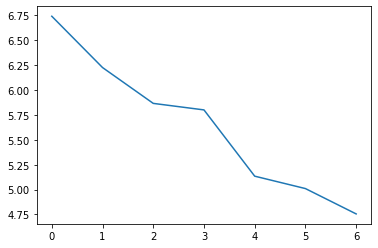

In [ ]:
plt.plot(Sigma)

#### Interpretando los tópicos


La siguiente función solo toma la matriz de VT y obtiene las 8 palabras más importantes en este topico. Si quieren pueden variar este parametro para ver más palabras e inspeccionar los tópicos. Esto es importante porque LSI es un método no supervisado, por lo tanto no sabemos a priori cuando un tópico es bueno o malo. El sentido debemos darselo nosotros:

In [ ]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[-8:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(VT)

['medalla querer ganar gustar comprar cerveza cruzcampo',
 'olimpia nikes siempre nuevo zapatilla camiseta adidas',
 'comprar nuevo conocer gustar aldub81stweeksary superstar cruzcampo',
 'bueno querer invitar beber arruinaunacitacon4palabras cerveza gustar',
 '10 terminar carrera milka ritmar correr acabo',
 'alfajor querer ganar carrefour comprar mercadona chocolate',
 'panga vender movistar mejor comprar bimbo carrefour']

Limitaciones en LSI:
 - LSI sufre de un problema llamado "Indeterminación del signo", que básicamente significa que el signo en la matríz VT y USigma dependen del algorimo que se utilizó para generarlos y de las condiciones iniciales (initial random state). En este contexto, que significa que un tópico esté relacionado con una palabra en un valor negativo?

### NMF: Non-negative Matrix Factorization

Motivación: En lugar de construir nuestros factores imponiendo la restricción de que sean ortogonales, la idea es de construirlos de tal forma que sean no-negativos.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=7, random_state = 1234)

In [ ]:
W1 = nmf.fit_transform(vectors)
H1 = nmf.components_

En este caso, la matriz que nos interesa es H1

In [ ]:
H1.shape

(7, 6729)

#### Interpretando los tópicos

In [ ]:
show_topics(H1)

['novio comprar querer corona medalla cerveza ganar',
 'olimpia color nikes siempre nuevo zapatilla camiseta',
 'tenis napaacc cliente nuevo conocer aldub81stweeksary superstar',
 'mahou invitar querer beber arruinaunacitacon4palabras cerveza gustar',
 '50 10 terminar carrera ritmar correr acabo',
 'mcflurry necesito quiero querer alfajor ganar chocolate',
 'panga vender movistar mejor comprar bimbo carrefour']

### LDA: Latent Dirichlet Allocation

LDA es un método Bayesiano basado en la distribución de Dirichlet, la cual es una distribución sobre probabilidades en K categorias. LDA supone que los documentos que tenemos pertenecen a K categorias distintas cuya distribución es desconocida, sin embargo, asume que todos los fragmentos que componen el texto fueron generados a través de un mismo proceso generativo. 

La distribución Dirichlet es una generalización de la distribución Beta en un espacio multidimensional. Así como la distribución beta es la distribución previa de la binomial, la distribución de Dirichlet es la distribución previa de la multinomial. 

$$ P(w\mid d) = P(d)\sum_c P(k\mid d)P(w\mid k) $$

*¿Notan alguna similitud con SVD?*

David Blei, Andrew Ng, Michael Jordan:  Latent Dirichlet Allocation [https://jmlr.org/papers/volume3/blei03a/blei03a.pdf]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7)

In [ ]:
lda.fit(vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
for idx, topic in enumerate(lda.components_):
    print ("Topic ", idx, " ".join(vocab[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 cruzcampo milka heineken toyota gustar bimbo carrefour cerveza llevar arruinaunacitacon4palabras
Topic  1 adir adidas mercadona bimbo comprar heineken alcampo milka barato supermercado
Topic  2 querer heineken adidas mercadona ir movistar banco poder hacendar vez
Topic  3 galicia carrefour estrella movistar banco mercadona heineken soler sabadell bueno
Topic  4 movistar toyota heineken mercadona adidas favor suzuki hacer vender adir
Topic  5 heineken nikeplus acabo correr ritmar santander mejor bimbo mercadona cerveza
Topic  6 heineken mueble bankia adir montar encontrar vestir quien medalla carrefour
